## Retail Trade Sales

### Data Cleaning and Wrangling

In [1]:
# Imports

import pandas as pd
import matplotlib.pyplot as plt
from pytrends.request import TrendReq
import json
import matplotlib
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.preprocessing import StandardScaler

In [2]:
# Reading file

retailsales=pd.read_csv('../../data/retailsalesbyIndustry/retailSalesbyIndustry.csv')

In [3]:
# Renaming columns as per required
retailsales.rename(columns = {'REF_DATE':'DATE', 
                                            'GEO':'LOCATION',
                                            'North American Industry Classification System (NAICS)':'INDUSTRY',
                                            'Adjustments':'ADJUSTMENTS'
                                           },inplace = True)

In [4]:
# Filtering columns as needed and extracting required columns
retailsales_filtered=retailsales[(retailsales['LOCATION'] == 'Canada') & 
                 (retailsales['INDUSTRY'] == 'Retail trade [44-45]')&
                 (retailsales['ADJUSTMENTS'] == 'Seasonally adjusted')&
                 (retailsales['DATE'] >= '2004-01')]
retailsales_final = retailsales_filtered[['DATE', 'VALUE']].copy()

#Changing data type of date
retailsales_final['DATE'] =  pd.to_datetime(retailsales_final['DATE'])
retailsales_final.reset_index(drop=True)

,DATE,VALUE
0,2004-01-01,27935993.0
1,2004-02-01,28719948.0
2,2004-03-01,28689514.0
3,2004-04-01,28254086.0
4,2004-05-01,28554094.0
...,...,...
213,2021-10-01,58218955.0
214,2021-11-01,58750669.0
215,2021-12-01,57919779.0
216,2022-01-01,59857374.0


In [5]:
# plot

# retailsales_date=retailsales_final.set_index('DATE')

# plt.plot(retailsales_date)
# plt.show()

In [6]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

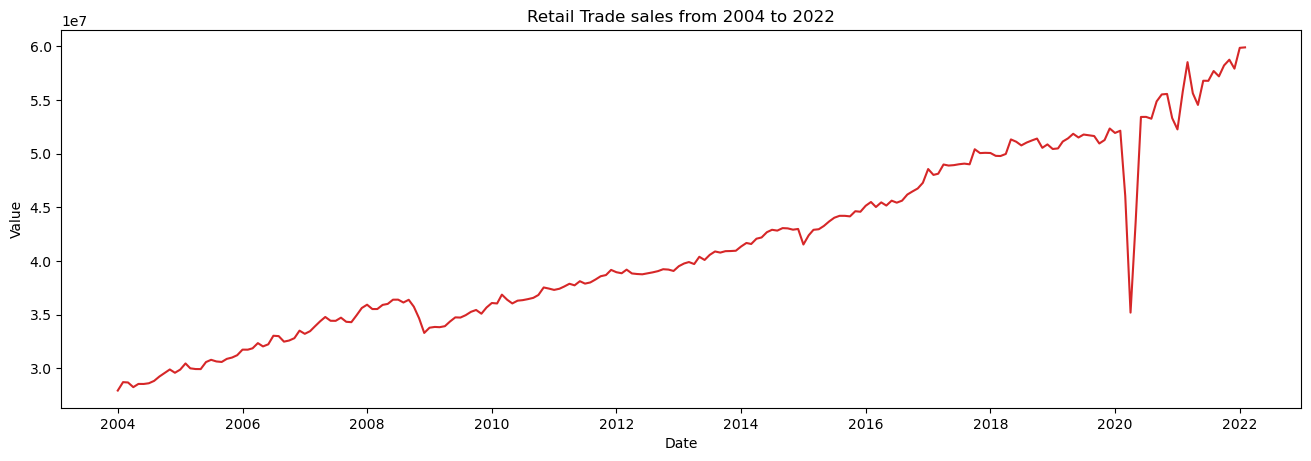

In [7]:
plot_df(retailsales_final, 
        x=retailsales_final.DATE, 
        y=retailsales_final.VALUE, 
        title='Retail Trade sales from 2004 to 2022')    

### Cleaning and using Time Series Data

#### Adding column for growth rate

In [8]:
retailsales_final['GrowthRate']=retailsales_final['VALUE'].pct_change()
retailsales_final=retailsales_final.reset_index(drop=True)
retailsales_final = retailsales_final.dropna()
retailsales_final

,DATE,VALUE,GrowthRate
1,2004-02-01,28719948.0,0.028063
2,2004-03-01,28689514.0,-0.001060
3,2004-04-01,28254086.0,-0.015177
4,2004-05-01,28554094.0,0.010618
5,2004-06-01,28550528.0,-0.000125
...,...,...,...
213,2021-10-01,58218955.0,0.017790
214,2021-11-01,58750669.0,0.009133
215,2021-12-01,57919779.0,-0.014143
216,2022-01-01,59857374.0,0.033453


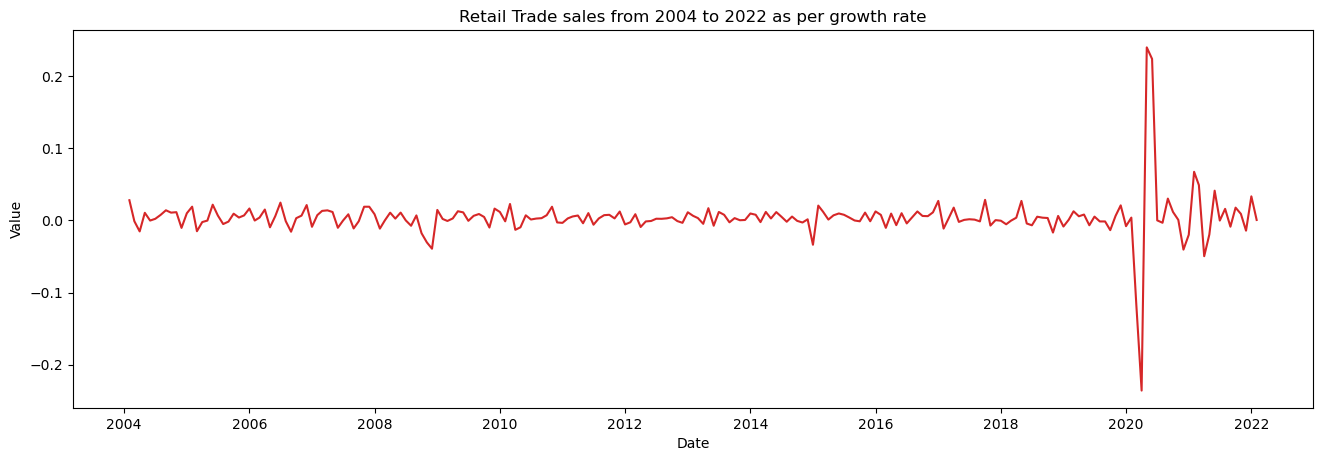

In [9]:
# Plot for growth rate
plot_df(retailsales_final, 
        x=retailsales_final.DATE, 
        y=retailsales_final.GrowthRate, 
        title='Retail Trade sales from 2004 to 2022 as per growth rate') 

#### Check for stationarity

In [10]:
# source link: https://www.statsmodels.org/devel/examples/notebooks/generated/stationarity_detrending_adf_kpss.html

def adf_test(timeseries):
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    if dftest[1] < 0.05:
        print("Series is stationary")
    else:
        print("Series is not stationary")


def kpss_test(timeseries):
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    if kpsstest[1] > 0.05:
        print("Series is stationary")
    else:
        print("Series is not stationary")

In [11]:
adf_test(retailsales_final['GrowthRate'])

Series is stationary


In [12]:
kstest = kpss_test(retailsales_final['GrowthRate'])

Series is stationary


/Users/aishwaryasharma/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


## Calculating keywords using Google Trends

In [13]:
# Reading file for Categories
retailcat=pd.read_csv('../../data/keywords_data/RETAIL_SALES.csv')

In [14]:
retailcatdat = retailcat[['CatNo']].copy()

### Function to get the queries, topics and thus keywords using pytrends

In [20]:
pytrends = TrendReq(hl='en-US', tz=360, backoff_factor=0.1)

def get_trend(keyword=[''], category='0'):
    """ Function for getting trends for selected keywords
        
        arguments: 
        
        Keywords: data type is string: stores list of keywords
        category: data type is string: stores the code for category
        
        returns: google trend data, related queries and related topics as a data frame  
    """
    
    kw_list=keyword
    cat=category
    timeframe='2004-01-20 2022-01-01'
    geo ='CA'
    gprop =''
    
    pytrends.build_payload(kw_list, cat, timeframe, geo, gprop)
    data = pytrends.interest_over_time()
    queries = pytrends.related_queries()
    topics = pytrends.related_topics()
    return data, queries, topics

In [21]:
keywordsDictQuery = dict() #Dictionary for queries
keywordsDictTopic = dict() #Dictionary for topic


for index, row in retailcatdat.iterrows():
    
    #Calling function
    data, queries, topics = get_trend(keyword=[''],category=str(row['CatNo']))
    
    
    #Code to append data for different columns in data frame
    
    if index==0:
        FinalData, queries, topics=get_trend(keyword=[''],category=str(row['CatNo']))
        FinalData.rename(columns = {'':str(row['CatNo'])}, inplace = True)
        FinalData=FinalData.drop(columns=['isPartial'])
    else:
        data, queries, topics=get_trend(keyword=[''],category=str(row['CatNo']))
        data.rename(columns = {'':str(row['CatNo'])}, inplace = True)
        data=data.drop(columns=['isPartial'])
        data = data[str(row['CatNo'])]
        FinalData = FinalData.join(data)
    
    #Code to store queries in a dictionary
    queries = queries['']['top']
    top5_query = pd.DataFrame(queries['query'].copy().head(5))
    top5_query = top5_query['query'].values.tolist()  
    keywordsDictQuery[str(row['CatNo'])] = top5_query
    
    #Code to store topics in a dictionary
    topics = topics['']['top']
    top5_topic = pd.DataFrame(topics['topic_title'].copy().head(5))
    top5_topic = top5_topic['topic_title'].values.tolist()
    keywordsDictTopic[str(row['CatNo'])] = top5_topic

In [22]:
FinalData

,841,47,1190,1191,1140,1213,1013,1214,806,810,...,355,1146,18,1225,270,659,1268,38,844,614
date,,,,,,,,,,,,,,,,,,,,,
2004-02-01,48,88,84,57,56,58,100,89,94,83,...,84,32,82,48,83,89,15,92,100,89
2004-03-01,44,94,69,77,67,64,83,93,97,86,...,91,29,81,51,88,89,23,93,80,87
2004-04-01,47,92,94,93,72,72,91,98,100,91,...,81,32,81,53,79,82,21,94,91,93
2004-05-01,48,94,65,96,73,76,90,89,100,98,...,78,33,80,50,74,80,42,93,89,69
2004-06-01,46,89,76,97,84,74,76,88,85,75,...,79,34,79,51,74,80,21,90,83,78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-01,65,44,25,31,35,60,27,68,21,48,...,27,17,47,80,83,38,16,58,30,29
2021-10-01,65,43,25,26,26,47,26,64,20,59,...,24,21,49,83,86,40,26,55,29,37
2021-11-01,70,43,27,24,24,34,26,59,20,64,...,27,25,58,93,91,42,24,60,31,36


### Getting Google Trends Data for the Keywords (queries and topics)

In [25]:
FinalData.to_csv('FinalRetailData2.csv')

In [29]:
retailsales1=pd.read_csv('../../src/notebooks/FinalRetailData.csv')
retailsales2=pd.read_csv('../../src/notebooks/FinalRetailData2.csv')

In [32]:
retailsales1 = retailsales1.set_index('date')
retailsales2 = retailsales2.set_index('date')

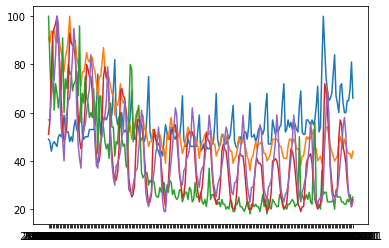

In [39]:
plt.plot(retailsales1[retailsales1.columns[0:5]])
plt.show()

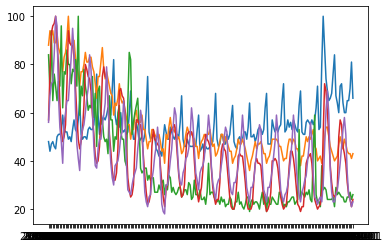

In [44]:
plt.plot(retailsales2[retailsales2.columns[0:5]])
plt.show()

### Storing data in data frame

In [68]:
FinalData.to_csv('FinalRetailData.csv')

### Storing queries and topics in json form

In [69]:
#Queries
with open('queries.json', 'w') as fp:
    json.dump(keywordsDictQuery, fp,  indent=4)

In [70]:
#Topics
with open('topics.json', 'w') as fp:
    json.dump(keywordsDictTopic, fp,  indent=4)

### checking time series of the trends

In [16]:
retailtrends = pd.read_csv('../../src/notebooks/FinalRetailData.csv')
retailtrends = retailtrends.set_index(['date'])

In [17]:
kpss_test(retailtrends['47'])

Series is not stationary


/Users/aishwaryasharma/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


### Making time series stationary

#### Normalizing

In [52]:
scaler = StandardScaler()
scaler.fit(retailtrends)
scaled_df = pd.DataFrame(scaler.transform(retailtrends))
scaled_df

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,-0.660480,2.301790,3.279150,0.435808,0.872586,-0.367354,3.103429,0.811886,3.245533,2.428083,...,2.812178,0.236434,1.975897,-0.758083,1.765762,1.889495,-0.074226,1.769276,2.809605,1.332261
1,-0.772452,2.171494,2.247283,0.757841,0.872586,0.198736,3.995493,1.949656,2.518667,1.968716,...,2.198252,-0.207135,1.671211,-1.177558,1.083617,2.335723,-0.197181,1.842253,3.247991,1.688924
2,-1.220340,2.497234,1.524976,1.831284,1.496067,0.507513,2.912273,2.212218,2.726343,2.255820,...,2.556375,-0.502848,1.595039,-1.037733,1.570863,2.271976,0.786456,1.915231,2.152027,1.536068
3,-0.884424,2.432086,2.763216,2.690039,1.807808,0.816289,3.358305,2.562301,2.830181,2.485503,...,2.044770,-0.207135,1.595039,-0.897908,0.693820,1.825748,0.540547,1.988208,2.754807,1.841779
4,-0.772452,2.497234,1.267009,2.797383,1.932504,1.125066,3.358305,1.862135,2.778262,2.887450,...,1.942449,-0.133207,1.518868,-1.037733,0.206574,1.762001,3.245547,1.915231,2.590413,0.567984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,1.131072,-0.760158,-0.641945,-0.637635,-0.499072,0.301662,-0.655981,0.024199,-0.959903,0.016406,...,-0.717897,-1.316058,-0.994793,1.059641,1.083617,-0.915371,-0.074226,-0.565994,-0.587881,-1.419138
213,1.131072,-0.825306,-0.693538,-0.905996,-1.060205,-0.367354,-0.719700,-0.325884,-1.011821,0.648036,...,-0.871379,-1.020345,-0.842450,1.269379,1.375965,-0.787877,1.155320,-0.857902,-0.642679,-1.011523
214,1.690932,-0.825306,-0.538758,-1.013340,-1.184901,-1.036369,-0.719700,-0.851008,-0.959903,0.935140,...,-0.717897,-0.724633,-0.156906,1.968503,1.863211,-0.660383,0.909410,-0.493016,-0.533083,-1.062475
215,2.922623,-0.955602,-0.693538,-1.174357,-1.371946,-1.396609,-0.719700,-0.675967,-1.063740,0.016406,...,-0.564416,-0.576776,-0.233078,2.387978,1.668313,-0.851624,0.294638,-0.565994,-0.533083,-1.419138


#### Taking difference

In [53]:
scaled_df = scaled_df.diff().dropna()

In [54]:
scaled_df

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
1,-0.111972,-0.130296,-1.031867,0.322033,0.000000,0.566090,0.892063,1.137770,-0.726865,-0.459367,...,-0.613926,-0.443569,-0.304686,-0.419475,-0.682145,0.446229,-0.122955,0.072977,0.438385,0.356663
2,-0.447888,0.325739,-0.722307,1.073443,0.623481,0.308776,-1.083220,0.262562,0.207676,0.287104,...,0.358124,-0.295713,-0.076172,0.139825,0.487246,-0.063747,0.983637,0.072977,-1.095963,-0.152855
3,0.335916,-0.065148,1.238240,0.858755,0.311741,0.308776,0.446032,0.350083,0.103838,0.229683,...,-0.511605,0.295713,0.000000,0.139825,-0.877043,-0.446229,-0.245909,0.072977,0.602780,0.305711
4,0.111972,0.065148,-1.496207,0.107344,0.124696,0.308776,0.000000,-0.700166,-0.051919,0.401946,...,-0.102321,0.073928,-0.076172,-0.139825,-0.487246,-0.063747,2.705000,-0.072977,-0.164394,-1.273796
5,-0.111972,-0.260591,0.567527,0.107344,0.623481,-0.051463,-0.892063,-0.087521,-0.623027,-1.378101,...,-0.051161,0.147856,0.000000,0.069912,0.000000,0.000000,-2.705000,-0.218932,-0.328789,0.509518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,0.559860,-0.195444,0.103187,-0.429377,-0.997570,-0.926329,0.127438,0.175042,-0.155757,-0.172263,...,0.000000,0.000000,0.000000,-0.069912,0.097449,0.000000,-0.491818,0.291909,0.054798,0.101904
213,0.000000,-0.065148,-0.051593,-0.268361,-0.561133,-0.669016,-0.063719,-0.350083,-0.051919,0.631630,...,-0.153482,0.295713,0.152343,0.209737,0.292348,0.127494,1.229546,-0.291909,-0.054798,0.407615
214,0.559860,0.000000,0.154780,-0.107344,-0.124696,-0.669016,0.000000,-0.525125,0.051919,0.287104,...,0.153482,0.295713,0.685544,0.699125,0.487246,0.127494,-0.245909,0.364886,0.109596,-0.050952
215,1.231692,-0.130296,-0.154780,-0.161016,-0.187044,-0.360239,0.000000,0.175042,-0.103838,-0.918734,...,0.153482,0.147856,-0.076172,0.419475,-0.194898,-0.191241,-0.614773,-0.072977,0.000000,-0.356663


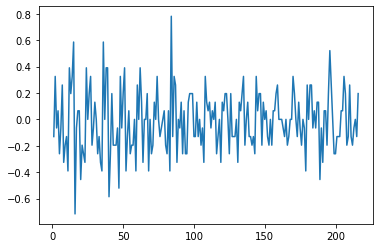

In [71]:
plt.plot(scaled_df[1])
plt.show()

In [128]:
# data, queries=get_trend(keyword=[''],category=str(retailcatdat['CatNo'].iloc[0]))
# queries = queries['']['top']
# top5 = pd.DataFrame(queries['query'].copy().head(5))
# top5 = top5['query'].values.tolist()
# keywordsDict = dict()
# keywordsDict[str(retailcatdat['CatNo'].iloc[0])] = top5
# keywordsDict

In [32]:
# from statsmodels.tsa.stattools import adfuller, kpss

# result = adfuller(retailsales_final.GrowthRate.values, autolag='AIC')

# print(f'ADF Statistic: {result[0]}')
# print(f'p-value: {result[1]}')
# for key, value in result[4].items():
#     print('Critial Values:')
#     print(f'   {key}, {value}')

# # KPSS Test
# result = kpss(retailsales_final.GrowthRate.values, regression='c')

# print('\nKPSS Statistic: %f' % result[0])
# print('p-value: %f' % result[1])
# for key, value in result[3].items():
#     print('Critial Values:')
#     print(f'   {key}, {value}')
